In [ ]:
# Install specific versions of numpy, torchdata, and DGL
!pip install numpy==1.23.5
!pip install --upgrade torchdata==0.6.0
!pip install --upgrade dgl


  Using cached torchdata-0.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (892 bytes)
  Using cached torch-2.0.0-cp311-cp311-manylinux1_x86_64.whl.metadata (24 kB)
Using cached torchdata-0.6.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.6 MB)
Using cached torch-2.0.0-cp311-cp311-manylinux1_x86_64.whl (619.9 MB)
  Attempting uninstall: torchdata
    Found existing installation: torchdata 0.11.0
    Uninstalling torchdata-0.11.0:
      Successfully uninstalled torchdata-0.11.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.21.0+cu124 requires torch==2.6.0, but you have torch 2.0.0 which is incompatible.
torchtune 0.6.1 requires torchdata==0.11.0, but you have torchdata 0.6.0 which is incompatible.
torchaudio 2.6.0+cu124 requires torch==2.6.0, but you have torch 2.0.0 which is incompatible.
  Using cached d

# New section

In [11]:
def compute_box_dimension(
        G,
        plot='off',
        count_diameter_less_nine='on'     # Default set to 'on'
    ):
    """
    Compute the box dimension of graph G.

    Returns: (R^2, box_dimension); returns (0, 0) if fewer than two data points are available.
    """
    import networkx as nx
    import numpy as np
    import matplotlib.pyplot as plt
    from math import floor
    from sklearn.linear_model import LinearRegression

    # ---- 1. Preprocessing: convert to undirected and keep the largest connected component ----
    if not isinstance(G, nx.Graph):
        G = G.to_networkx()
    else:
        G = G.copy()

    if nx.is_directed(G):
        G = G.to_undirected()

    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len)).copy()

    # ---- 2. Diameter ----
    try:
        diameter = nx.diameter(G)
    except Exception as e:
        print("计算直径出错：", e)
        return (0, 0)

    # Skip small diameters if the user explicitly requests
    if diameter <= 9 and count_diameter_less_nine == 'off':
        return None

    max_l = max(1, floor(diameter / 2))
    l_values, N_box_values = [], []

    # ---- 3. Box covering ----
    for l in range(1, max_l + 1):
        uncovered = set(G.nodes())
        box_count = 0
        r = l // 2

        if l % 2 == 0:  # Single center
            while uncovered:
                best_center, best_cov = None, set()
                for node in uncovered:
                    cov = set(nx.single_source_shortest_path_length(G, node, cutoff=r).keys()) & uncovered
                    if len(cov) > len(best_cov):
                        best_cov, best_center = cov, node
                uncovered -= best_cov
                box_count += 1
        else:           # Try double centers
            while uncovered:
                best_pair, best_union = None, set()
                for u in uncovered:
                    for v in G.neighbors(u):
                        if v not in uncovered:
                            continue
                        cov_u = set(nx.single_source_shortest_path_length(G, u, cutoff=r).keys())
                        cov_v = set(nx.single_source_shortest_path_length(G, v, cutoff=r).keys())
                        union_cov = (cov_u | cov_v) & uncovered
                        if len(union_cov) > len(best_union):
                            best_union, best_pair = union_cov, (u, v)
                if best_union:
                    uncovered -= best_union
                else:  # Fallback to single center
                    best_center, best_cov = None, set()
                    for node in uncovered:
                        cov = set(nx.single_source_shortest_path_length(G, node, cutoff=r).keys()) & uncovered
                        if len(cov) > len(best_cov):
                            best_cov, best_center = cov, node
                    uncovered -= best_cov
                box_count += 1

        l_values.append(l)
        N_box_values.append(box_count)

    # ---- 4. Skip regression if only one data point ----
    if len(l_values) < 2:
        return (0, 0)

    # ---- 5. Log–log regression ----
    log_l = np.log(np.array(l_values)).reshape(-1, 1)
    log_N_box = np.log(np.array(N_box_values))

    reg = LinearRegression().fit(log_l, log_N_box)
    m, b = reg.coef_[0], reg.intercept_
    R2 = reg.score(log_l, log_N_box)
    box_dimension = -m

    # ---- 6. Optional plot ----
    if plot == 'on':
        plt.figure(figsize=(6, 4))
        plt.scatter(l_values, N_box_values, label='data')
        x = np.linspace(min(l_values), max(l_values), 100)
        plt.plot(x, np.exp(b) * x**m, label=f'fit: N={np.exp(b):.2f}·l^{m:.2f}')
        plt.xscale('log'); plt.yscale('log')
        plt.xlabel('l'); plt.ylabel('N_box(l)')
        plt.title(f'R²={R2:.3f}, dim_B={box_dimension:.3f}')
        plt.legend(); plt.show()

    return (R2, box_dimension)


In [12]:
# ================= 0. Dependencies & Drive Mount =================
from google.colab import drive
drive.mount('/content/drive')  # Skip if already mounted

import pandas as pd
import numpy as np

# =============== Dataset list & path template ================
datasets = ['PROTEINS', 'MUTAG', 'NCI1', 'DD', 'REDDIT-BINARY', 'REDDIT-MULTI-5K']
csv_template = '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/{}_graph_features.csv'

# =============== Containers for all datasets ================
dfs = {}
labels_dict = {}
features_dict = {}

# =============== Batch loading & extraction ================
for name in datasets:
    path = csv_template.format(name)
    print(f'Loading {name} from {path}...')
    df = pd.read_csv(path)
    dfs[name] = df

    # Extract graph_id and label
    graph_ids = df['graph_id'].to_numpy(dtype=int)
    labels   = df['label'].to_numpy(dtype=int)
    labels_dict[name] = labels

    # Extract all other feature columns and store as a dict of NumPy arrays
    feature_arrays = {}
    for col in df.columns:
        if col in ['graph_id', 'label']:
            continue
        # Reshape into column vectors
        feature_arrays[col] = df[col].to_numpy(dtype=float).reshape(-1, 1)

    features_dict[name] = feature_arrays

    print(f'  → {name}: {df.shape[0]} graphs, {len(feature_arrays)} features.')

print('All datasets loaded:', list(dfs.keys()))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading PROTEINS from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/PROTEINS_graph_features.csv...
  → PROTEINS: 1113 graphs, 4 features.
Loading MUTAG from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/MUTAG_graph_features.csv...
  → MUTAG: 188 graphs, 4 features.
Loading NCI1 from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/NCI1_graph_features.csv...
  → NCI1: 4110 graphs, 4 features.
Loading DD from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/DD_graph_features.csv...
  → DD: 1178 graphs, 4 features.
Loading REDDIT-BINARY from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-BINARY_graph_features.csv...
  → REDDIT-BINARY: 2000 graphs, 4 features.
Loading REDDIT-MULTI-5K from /content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-MULTI-5K_graph_features.csv.

In [13]:
# =============== R² distribution at different thresholds ================
thresholds = [0.5, 0.8, 0.9, 0.95]

print('\n=== Fractality R² threshold statistics ===')
for name, df in dfs.items():
    # ------ 1) Locate the R² column ------
    r2_candidates = [c for c in df.columns if 'r2' in c.lower() or 'r^2' in c.lower()]
    if not r2_candidates:
        raise ValueError(
            f'No R² column found for dataset {name}. '
            'Please set r2_col manually.'
        )
    r2_col = r2_candidates[0]   # Default to the first matched column
    r2_vals = df[r2_col].to_numpy(dtype=float)

    total = len(r2_vals)
    print(f'\n{name}  (total {total} graphs)')
    print(f'  Using R² column: {r2_col}')

    # ------ 2) Count for each threshold ------
    for thr in thresholds:
        cnt = (r2_vals > thr).sum()
        pct = 100.0 * cnt / total
        print(f'    R² > {thr:<4} : {cnt:>5d} graphs  ({pct:6.2f}%)')



=== Fractality R² threshold statistics ===

PROTEINS  (total 1113 graphs)
  Using R² column: R2
    R² > 0.5  :   979 graphs  ( 87.96%)
    R² > 0.8  :   968 graphs  ( 86.97%)
    R² > 0.9  :   905 graphs  ( 81.31%)
    R² > 0.95 :   711 graphs  ( 63.88%)

MUTAG  (total 188 graphs)
  Using R² column: R2
    R² > 0.5  :   188 graphs  (100.00%)
    R² > 0.8  :   172 graphs  ( 91.49%)
    R² > 0.9  :   136 graphs  ( 72.34%)
    R² > 0.95 :    74 graphs  ( 39.36%)

NCI1  (total 4110 graphs)
  Using R² column: R2
    R² > 0.5  :  4108 graphs  ( 99.95%)
    R² > 0.8  :  3979 graphs  ( 96.81%)
    R² > 0.9  :  3277 graphs  ( 79.73%)
    R² > 0.95 :  1817 graphs  ( 44.21%)

DD  (total 1178 graphs)
  Using R² column: R2
    R² > 0.5  :  1178 graphs  (100.00%)
    R² > 0.8  :  1178 graphs  (100.00%)
    R² > 0.9  :  1176 graphs  ( 99.83%)
    R² > 0.95 :  1155 graphs  ( 98.05%)

REDDIT-BINARY  (total 2000 graphs)
  Using R² column: R2
    R² > 0.5  :  1971 graphs  ( 98.55%)
    R² > 0.8  :  187

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

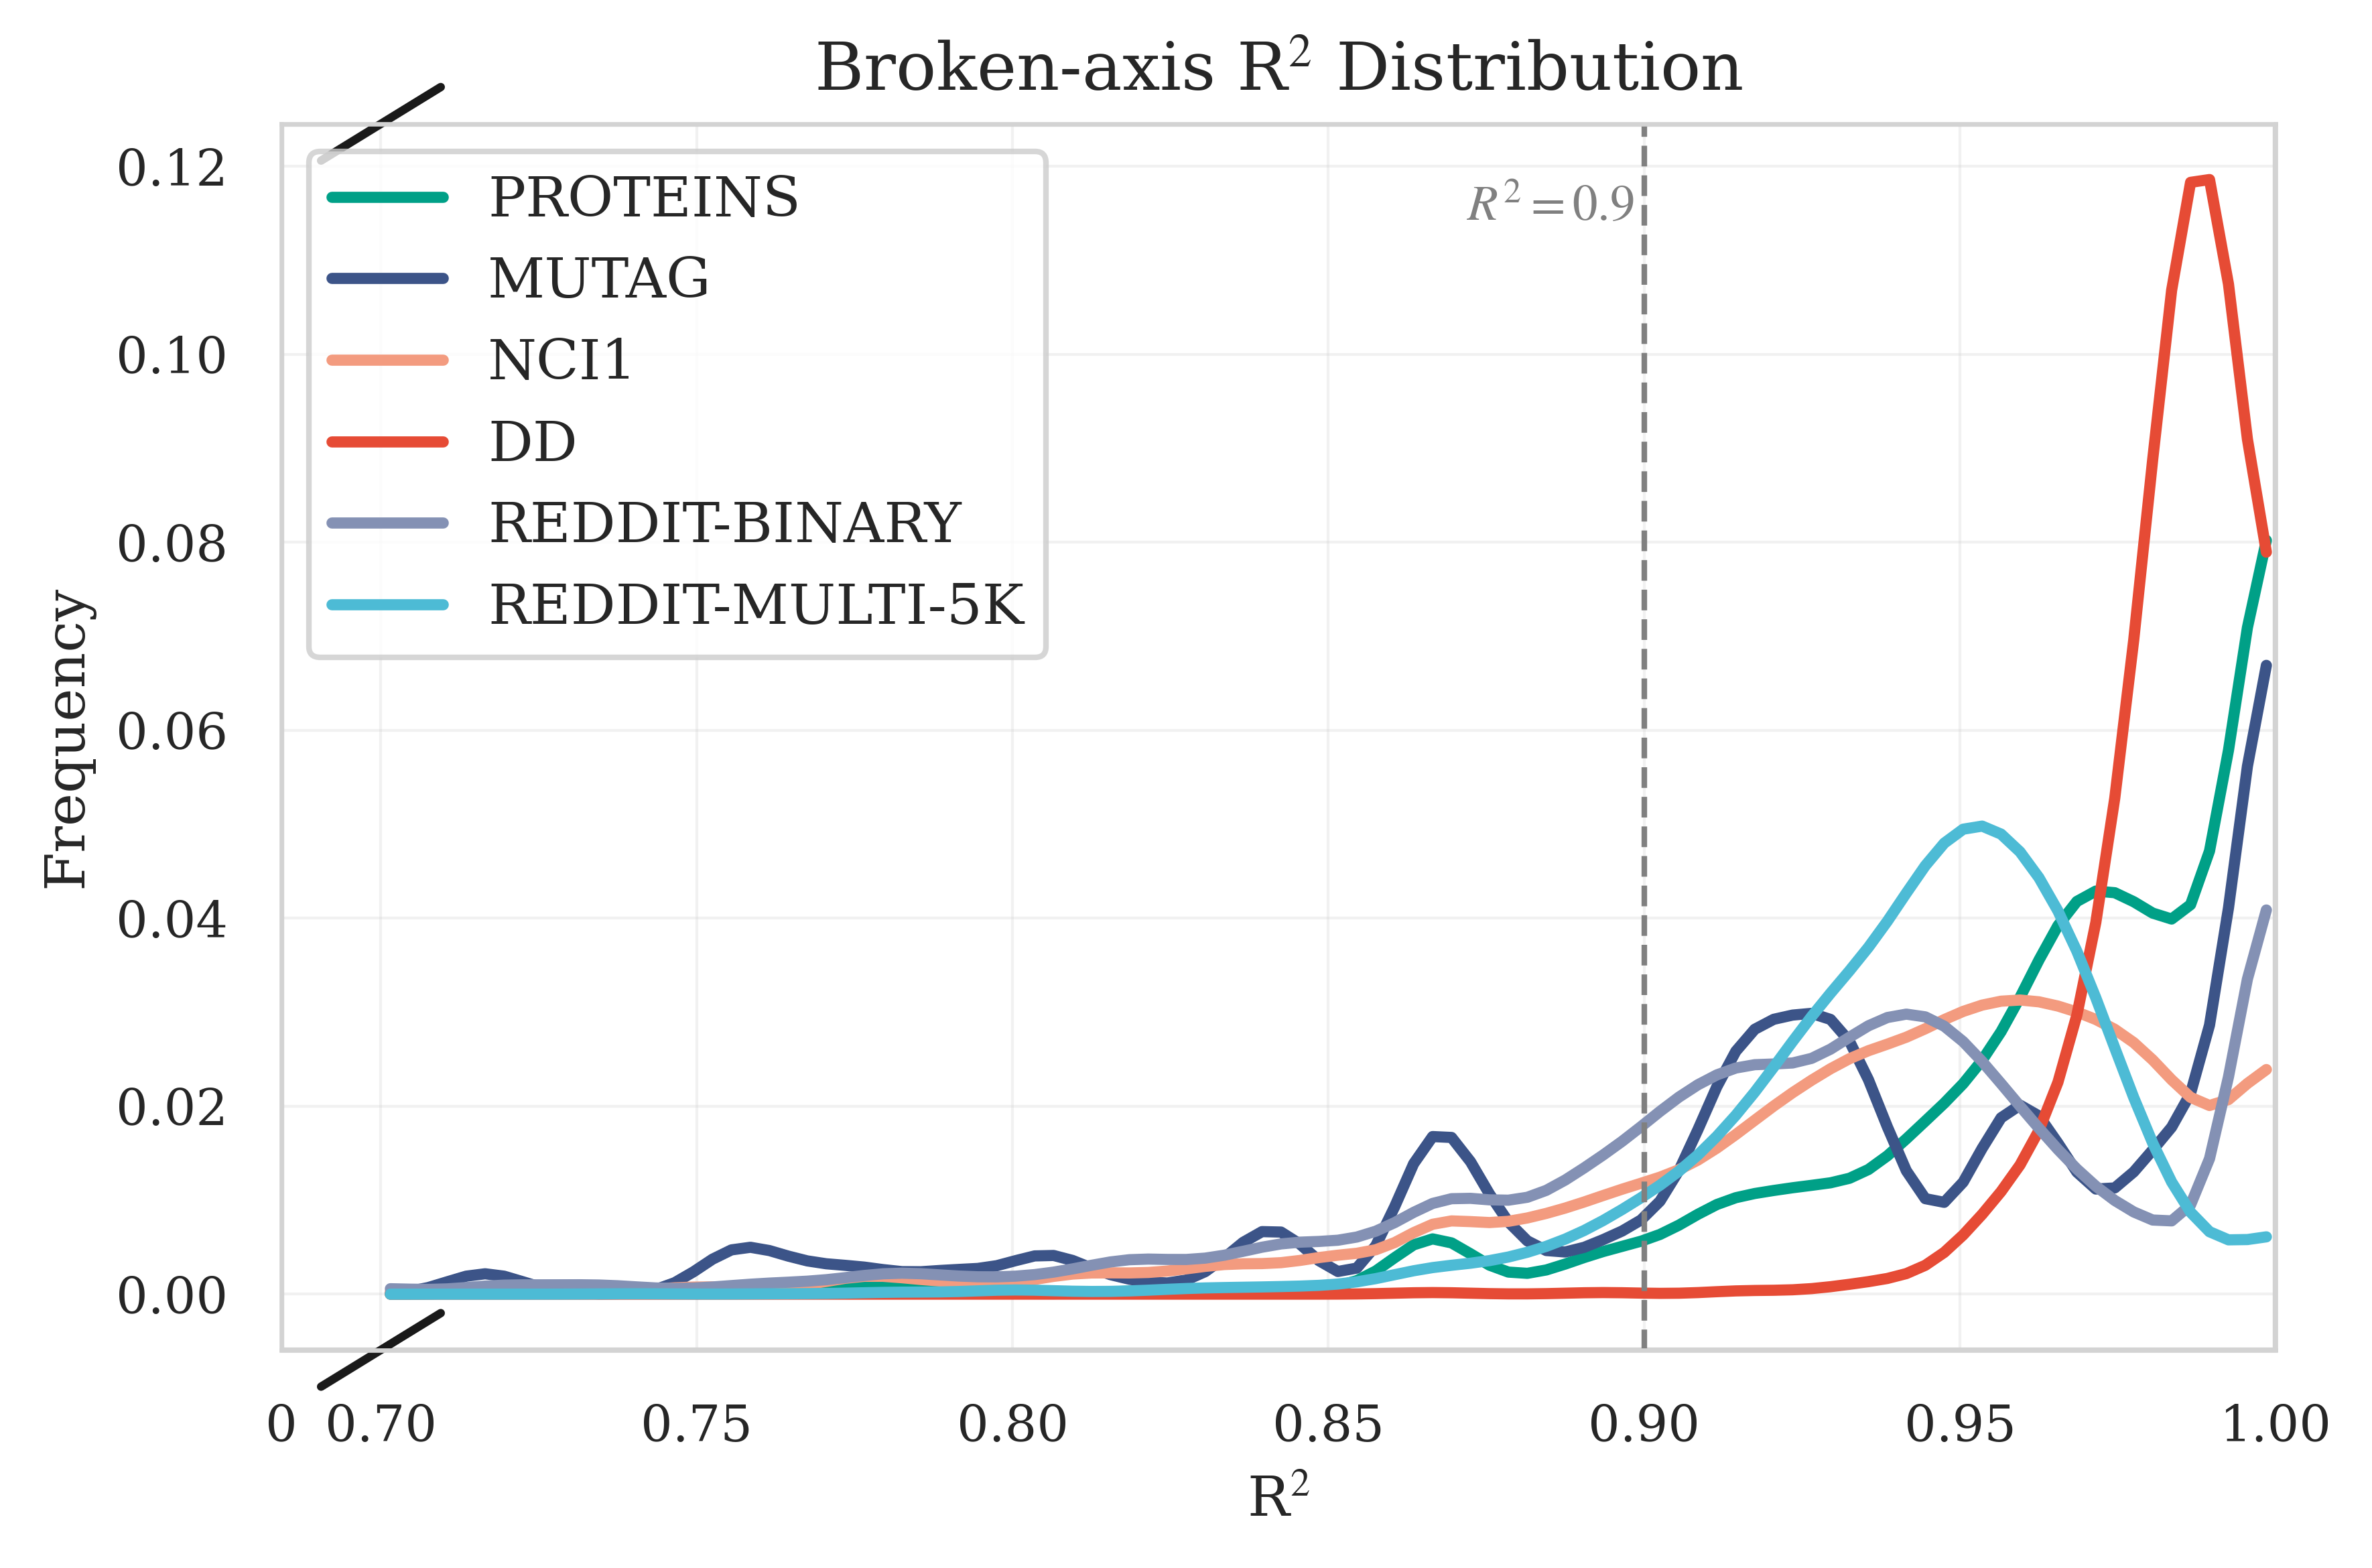

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.ndimage import gaussian_filter1d

# Adjustable parameters
bins      = 100
alpha     = 1.0
sigma     = 2
save_path = 'R2_distribution_broken_axis.png'

paths = {
    'PROTEINS'        : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/PROTEINS_graph_features.csv',
    'MUTAG'           : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/MUTAG_graph_features.csv',
    'NCI1'            : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/NCI1_graph_features.csv',
    'DD'              : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/DD_graph_features.csv',
    'REDDIT-BINARY'   : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-BINARY_graph_features.csv',
    'REDDIT-MULTI-5K' : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-MULTI-5K_graph_features.csv',
}
colors = {
    'PROTEINS'        : '#00A087',
    'MUTAG'           : '#3C5488',
    'NCI1'            : '#F39B7FFF',
    'DD'              : '#E64B35',
    'REDDIT-BINARY'   : '#8491B4',
    'REDDIT-MULTI-5K' : '#4DBBD5',
}

# Piecewise mapping function
def transform(x):
    x = np.array(x)
    disp = np.empty_like(x, dtype=float)
    mask1 = x <= 0.7
    disp[mask1] = x[mask1] * (0.05 / 0.7)
    mask2 = x > 0.7
    disp[mask2] = 0.05 + (x[mask2] - 0.7) * (0.95 / 0.3)
    return disp

# Prepare bins and centers (only for the 0.7–1.0 interval)
edges = np.linspace(0.7, 1.0, bins + 1)
centers = (edges[:-1] + edges[1:]) / 2

# Global style
plt.rcParams['font.family']      = 'serif'
plt.rcParams['font.serif']       = ['DejaVu Serif']
plt.rcParams['font.size']        = 10
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['mathtext.rm']      = 'DejaVu Serif'

fig, ax = plt.subplots(figsize=(6, 4))

# Plot six smoothed curves
for name, csv_path in paths.items():
    r2 = pd.read_csv(csv_path, usecols=['R2'])['R2'].to_numpy()
    r2 = r2[r2 > 0.7]
    total = len(r2)
    counts, _ = np.histogram(r2, bins=edges)
    freqs = counts / total
    smooth = gaussian_filter1d(freqs, sigma=sigma)
    x_disp = transform(centers)
    ax.plot(x_disp, smooth,
            color=colors[name],
            linewidth=2,
            alpha=alpha,
            label=name)

# Draw accentuated broken-axis slanted lines
d = .03  # The length of the diagonal break marker
ax.plot((0.05 - d, 0.05 + d), (-d, +d),
        color='k', transform=ax.transAxes, clip_on=False)
ax.plot((0.05 - d, 0.05 + d), (1-d, 1+d),
        color='k', transform=ax.transAxes, clip_on=False)

# R² = 0.9 reference line and annotation
x90 = transform(0.9)
ax.axvline(x90, color='gray', linestyle='--', linewidth=1)
ax.text(x90 - 0.005, ax.get_ylim()[1]*0.95, r'$R^2=0.9$',
        ha='right', va='top', fontsize=9, color='gray')

# Tick settings: 0, 0.7, 0.75 … 1.0
orig_ticks = np.arange(0.7, 1.01, 0.05)
disp_ticks = np.concatenate(([0], transform(orig_ticks)))
ax.set_xticks(disp_ticks)
ax.set_xticklabels(['0'] + [f'{t:.2f}' for t in orig_ticks])

ax.set_xlim(0, 1.0)
ax.set_xlabel('R$^2$')
ax.set_ylabel('Frequency')
ax.set_title('Broken-axis R$^2$ Distribution')
ax.grid(True, which='both', color='lightgray', linestyle='-', linewidth=0.5)

for spine in ax.spines.values():
    spine.set_color('lightgray')
rect = mpatches.Rectangle((0, 0), 1, 1,
                          transform=ax.transAxes,
                          fill=False, edgecolor='lightgray', linewidth=1)
ax.add_patch(rect)
ax.legend(frameon=True, loc='upper left', fontsize=10)

# Save and download
plt.tight_layout()
plt.savefig(save_path, dpi=300)

try:
    from google.colab import files
    files.download(save_path)
except ModuleNotFoundError:
    print(f'Figure saved to {save_path}')


In [17]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score
from scipy.stats import ttest_rel
from google.colab import files   # For downloading in Colab; comment out if not using Colab

# ---------- Paths to the six datasets ----------
paths = {
    'PROTEINS'         : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/PROTEINS_graph_features.csv',
    'MUTAG'            : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/MUTAG_graph_features.csv',
    'NCI1'             : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/NCI1_graph_features.csv',
    'DD'               : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/DD_graph_features.csv',
    'REDDIT-BINARY'    : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-BINARY_graph_features.csv',
    'REDDIT-MULTI-5K'  : '/content/drive/MyDrive/FractalGCL/pre_experiments/R2_num_data/REDDIT-MULTI-5K_graph_features.csv',
}

# ---------- Feature lists ----------
# The baseline contains two columns (e.g., degree_variance and avg_shortest_path)
baseline_feats = ['degree_variance', 'avg_shortest_path']
# Add box_dimension on top of baseline features
all_feats = baseline_feats + ['box_dimension']

# ---------- Container for results ----------
results = []

# ---------- 10-fold CV settings ----------
cv  = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)

for name, csv_path in paths.items():
    # 1) Load data
    df = pd.read_csv(csv_path)
    X_base = df[baseline_feats].values
    X_full = df[all_feats].values
    y      = df['label'].values

    # 2) Cross-validation
    scores_base = cross_val_score(clf, X_base, y, cv=cv)
    scores_full = cross_val_score(clf, X_full, y, cv=cv)

    # 3) Compute the increment and paired t-test
    delta = scores_full - scores_base
    t_stat, p_val = ttest_rel(scores_full, scores_base)

    # 4) Store results
    results.append({
        'Dataset'           : name,
        'Baseline mean'     : scores_base.mean(),
        'Baseline std'      : scores_base.std(),
        '+BoxDim mean'      : scores_full.mean(),
        '+BoxDim std'       : scores_full.std(),
        'ΔAcc (Full-Base)'  : delta.mean(),
        'p-value'           : p_val,
    })

    # 5) Print to console
    print(f'=== {name} ===')
    print(f'Baseline 10-fold Acc : {scores_base.mean():.4f} ± {scores_base.std():.4f}')
    print(f'+BoxDim 10-fold Acc  : {scores_full.mean():.4f} ± {scores_full.std():.4f}')
    print(f'ΔAcc = {delta.mean():+.4f}  (paired t-test p = {p_val:.3e})\n')

# ---------- Save as CSV and download ----------
out_df = pd.DataFrame(results)
csv_name = 'boxdim_incremental_results_6datasets.csv'
out_df.to_csv(csv_name, index=False)

try:
    files.download(csv_name)
except Exception:
    print(f'CSV saved to {csv_name}')


=== PROTEINS ===
Baseline 10-fold Acc : 0.6775 ± 0.0363
+BoxDim 10-fold Acc  : 0.6990 ± 0.0339
ΔAcc = +0.0215  (paired t-test p = 9.295e-02)

=== MUTAG ===
Baseline 10-fold Acc : 0.8354 ± 0.0592
+BoxDim 10-fold Acc  : 0.8564 ± 0.0667
ΔAcc = +0.0211  (paired t-test p = 2.695e-01)

=== NCI1 ===
Baseline 10-fold Acc : 0.6251 ± 0.0216
+BoxDim 10-fold Acc  : 0.6467 ± 0.0151
ΔAcc = +0.0217  (paired t-test p = 2.228e-02)

=== DD ===
Baseline 10-fold Acc : 0.6715 ± 0.0330
+BoxDim 10-fold Acc  : 0.7164 ± 0.0258
ΔAcc = +0.0450  (paired t-test p = 9.720e-04)

=== REDDIT-BINARY ===
Baseline 10-fold Acc : 0.7925 ± 0.0294
+BoxDim 10-fold Acc  : 0.8080 ± 0.0212
ΔAcc = +0.0155  (paired t-test p = 4.134e-02)

=== REDDIT-MULTI-5K ===
Baseline 10-fold Acc : 0.3333 ± 0.0158
+BoxDim 10-fold Acc  : 0.3819 ± 0.0171
ΔAcc = +0.0486  (paired t-test p = 2.250e-04)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

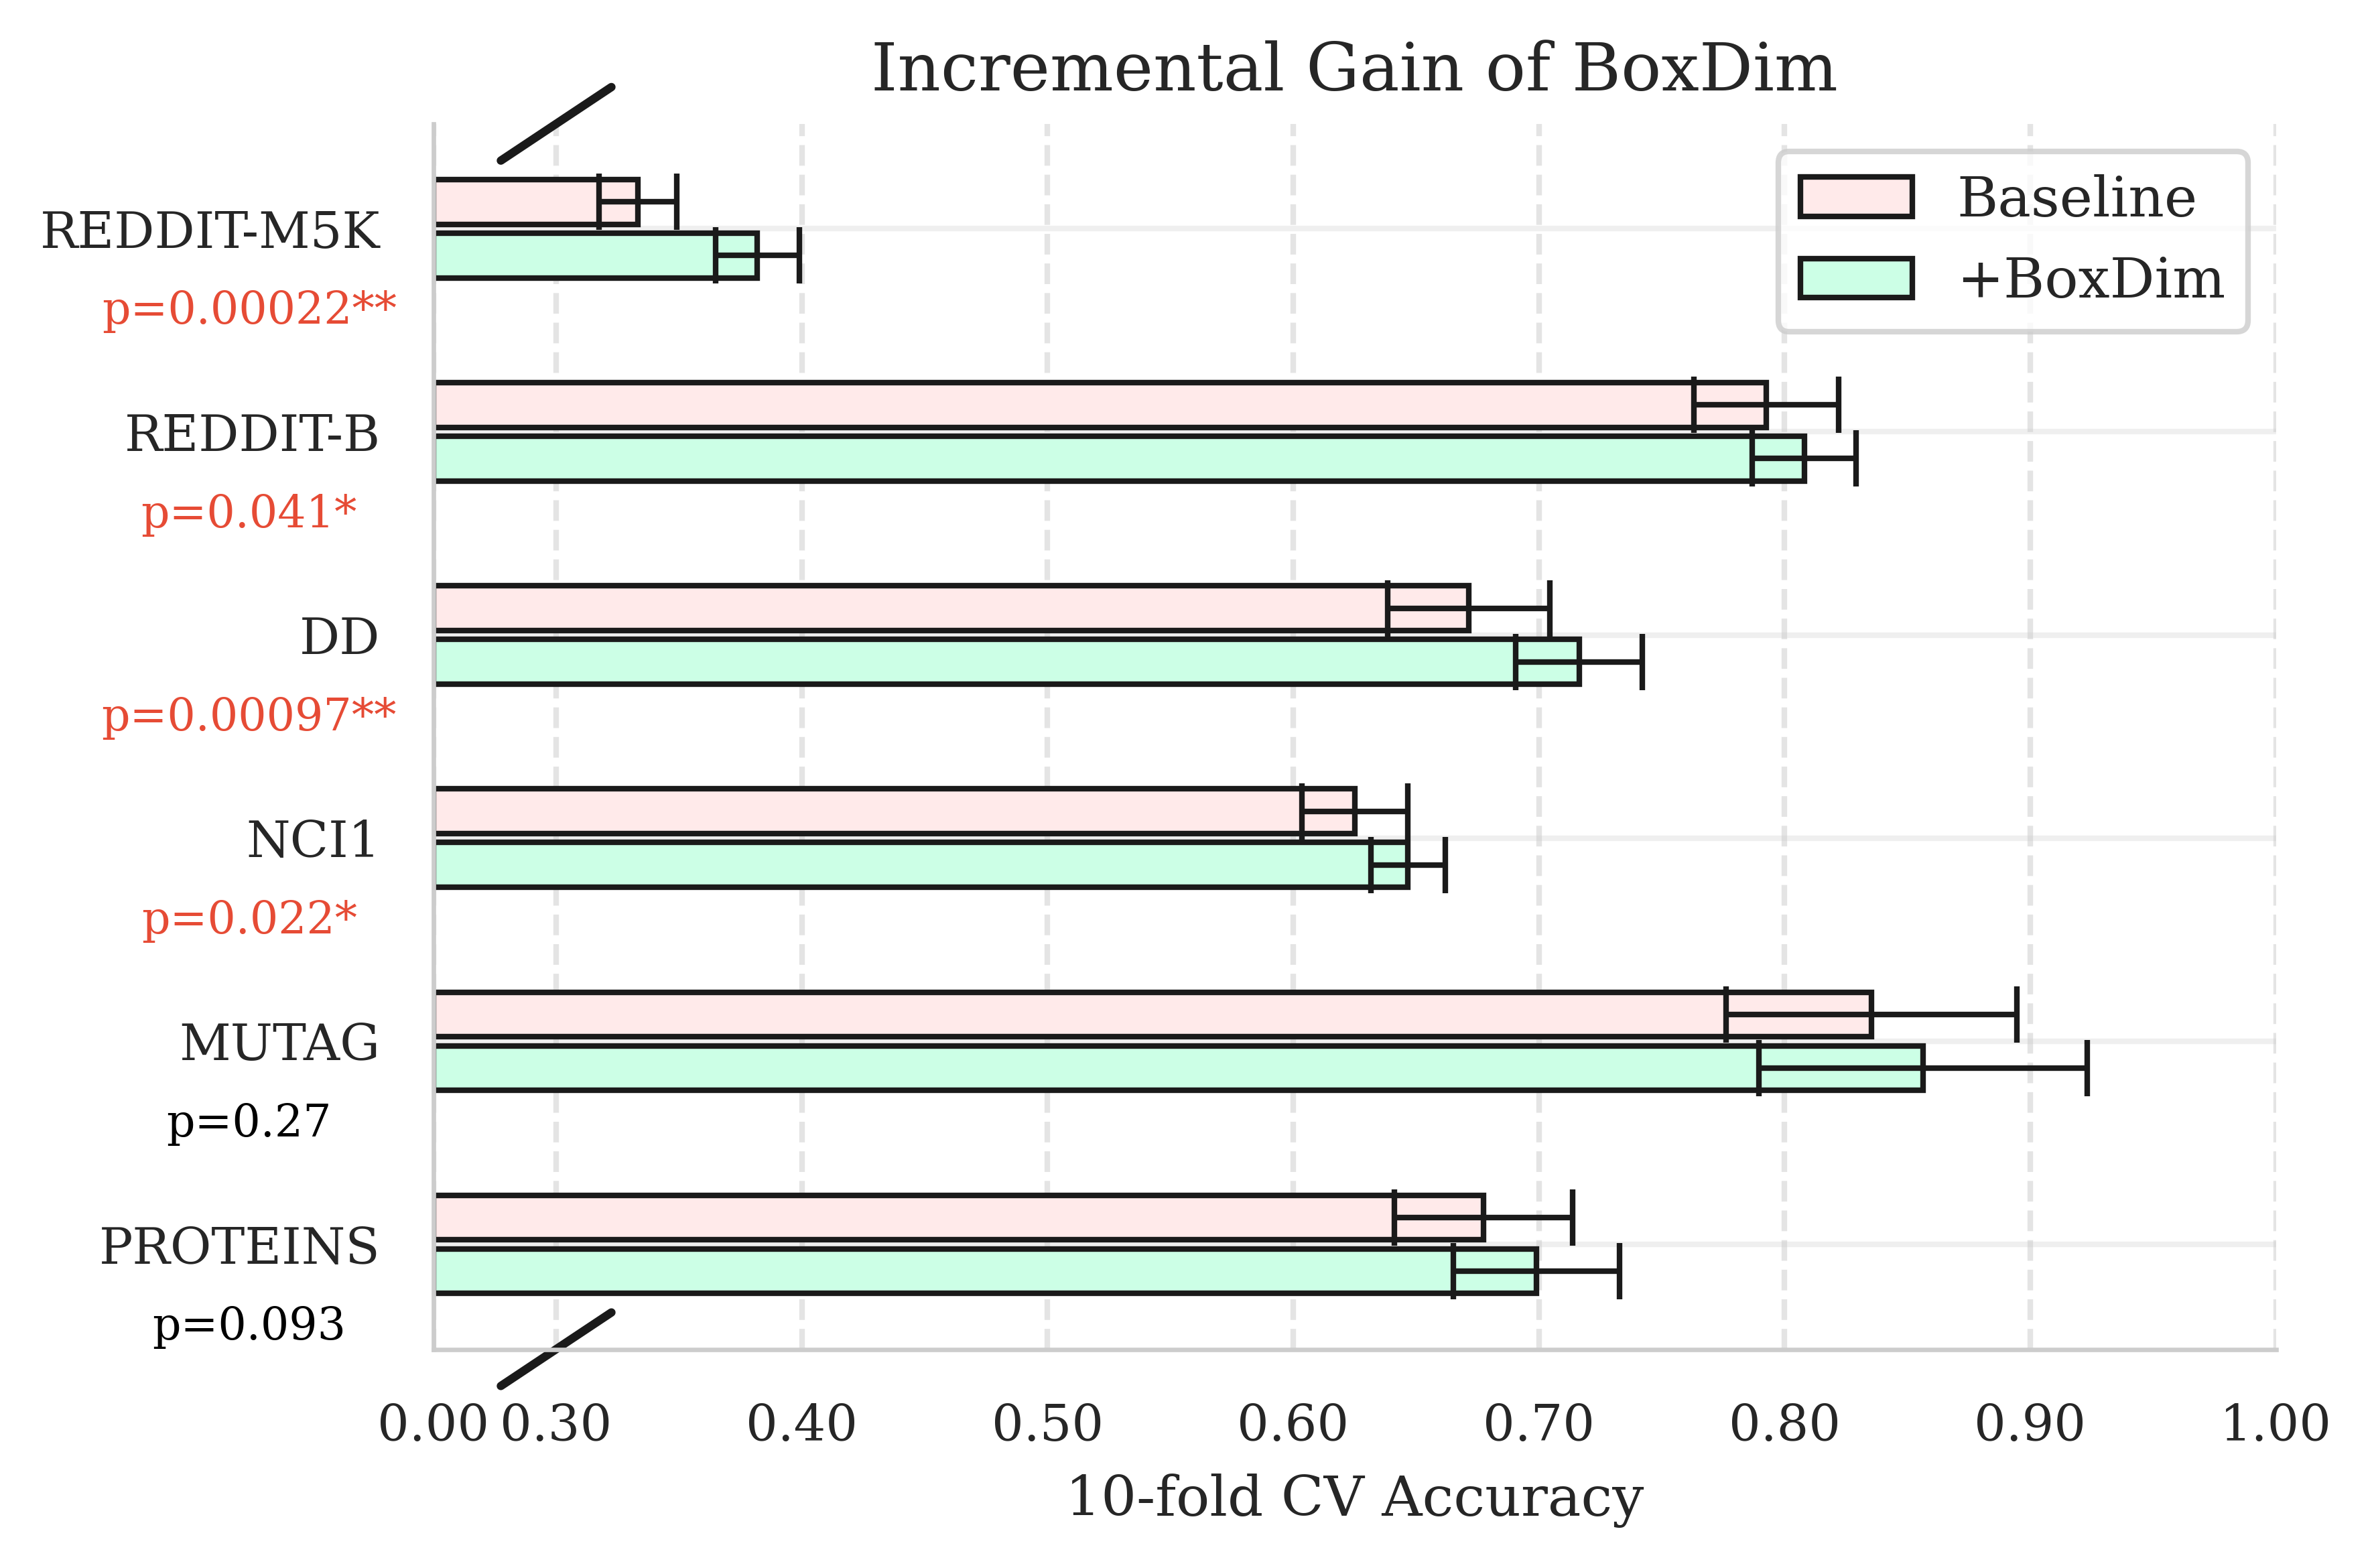

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# ---------- Experimental results ----------
data = {
    'Dataset': ['PROTEINS', 'MUTAG', 'NCI1', 'DD', 'REDDIT-BINARY', 'REDDIT-MULTI-5K'],
    'Baseline mean': [0.6775, 0.8354, 0.6251, 0.6715, 0.7925, 0.3333],
    'Baseline std' : [0.0363, 0.0592, 0.0216, 0.0330, 0.0294, 0.0158],
    '+BoxDim mean' : [0.6990, 0.8564, 0.6467, 0.7164, 0.8080, 0.3819],
    '+BoxDim std'  : [0.0339, 0.0667, 0.0151, 0.0258, 0.0212, 0.0171],
    'p-value'      : [0.09295, 0.2695, 0.02228, 0.0009720, 0.04134, 0.0002250]
}
df = pd.DataFrame(data)
df['Display'] = df['Dataset'].replace({
    'REDDIT-MULTI-5K': 'REDDIT-M5K',
    'REDDIT-BINARY'  : 'REDDIT-B'
})

# ---------- Piecewise mapping: compress 0–0.3 to 0–0.0667, expand 0.3–1 to 0.0667–1 ----------
a = 0.0666667  # Length of the compressed segment
def transform(x):
    x = np.array(x)
    disp = np.empty_like(x, dtype=float)
    mask1 = x <= 0.3
    disp[mask1] = x[mask1] * (a / 0.3)
    mask2 = x > 0.3
    disp[mask2] = a + (x[mask2] - 0.3) * ((1 - a) / 0.7)
    return disp

# ---------- Colors: light red and light blue ----------
color_base = '#FFEAEA'  # Light red
color_full = '#CCFFE6'  # Light blue

# Canvas & layout parameters
bar_h, gap = 0.22, 0.22 / 5
offset = bar_h / 2 + gap / 2
y = np.arange(len(df))

fig, ax = plt.subplots(figsize=(6, 4))
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 10

# Width mapping
width_base = transform(df['Baseline mean'])
width_full = transform(df['+BoxDim mean'])

# Draw bars and error bars
ax.barh(y + offset, width_base, height=bar_h, color=color_base, edgecolor='k')
ax.barh(y - offset, width_full, height=bar_h, color=color_full, edgecolor='k')
for i, row in df.iterrows():
    # Baseline error bars
    c  = transform(row['Baseline mean'])
    el = transform(row['Baseline mean'] - row['Baseline std'])
    er = transform(row['Baseline mean'] + row['Baseline std'])
    ax.errorbar(c, i + offset, xerr=[[c - el], [er - c]], fmt='none',
                ecolor='k', capsize=5, capthick=1, lw=1)
    # Full error bars
    cf  = transform(row['+BoxDim mean'])
    elf = transform(row['+BoxDim mean'] - row['+BoxDim std'])
    erf = transform(row['+BoxDim mean'] + row['+BoxDim std'])
    ax.errorbar(cf, i - offset, xerr=[[cf - elf], [erf - cf]], fmt='none',
                ecolor='k', capsize=5, capthick=1, lw=1)

# p-value annotation: red with star symbols, black otherwise
for i, row in df.iterrows():
    # Determine star symbols based on p-value
    stars = '**' if row['p-value'] < 0.01 else '*' if row['p-value'] < 0.05 else ''
    text_color = 'red' if stars else 'black'
    x_text = -0.1                # Place just below dataset name
    y_text = i - 0.3
    ax.text(x_text, y_text, f"p={row['p-value']:.2g}{stars}",
            va='top', ha='center', fontsize=8, color=text_color)

# Broken-axis symbol after mapping x = 0.3
d = .03
disp30 = transform(0.3)
ax.plot((disp30 - d, disp30 + d), (-d, +d),
        color='k', transform=ax.transAxes, clip_on=False)
ax.plot((disp30 - d, disp30 + d), (1 - d, 1 + d),
        color='k', transform=ax.transAxes, clip_on=False)

# Ticks and labels
orig_ticks = np.concatenate(([0.0, 0.3, 0.4], np.arange(0.5, 1.01, 0.1)))
disp_ticks = transform(orig_ticks)
ax.set_xticks(disp_ticks)
ax.set_xticklabels([f"{t:.2f}" for t in orig_ticks])

ax.set_yticks(y)
ax.set_yticklabels(df['Display'])
ax.set_xlabel('10-fold CV Accuracy')
ax.set_title('Incremental Gain of BoxDim')
ax.set_xlim(0, 1)
ax.grid(True, axis='x', linestyle='--', color='lightgray', alpha=0.6)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Legend
legend_handles = [
    mpatches.Patch(facecolor=color_base, edgecolor='k', label='Baseline'),
    mpatches.Patch(facecolor=color_full, edgecolor='k', label='+BoxDim')
]
ax.legend(handles=legend_handles, loc='upper right', fontsize=10, frameon=True)

# ========== Save and download ==========
save_path = 'boxdim_incremental_plot.png'
plt.tight_layout()
plt.savefig(save_path, dpi=300)
try:
    from google.colab import files
    files.download(save_path)
except Exception:
    print(f'Figure saved to {save_path}')

# Optionally display the image
plt.show()


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

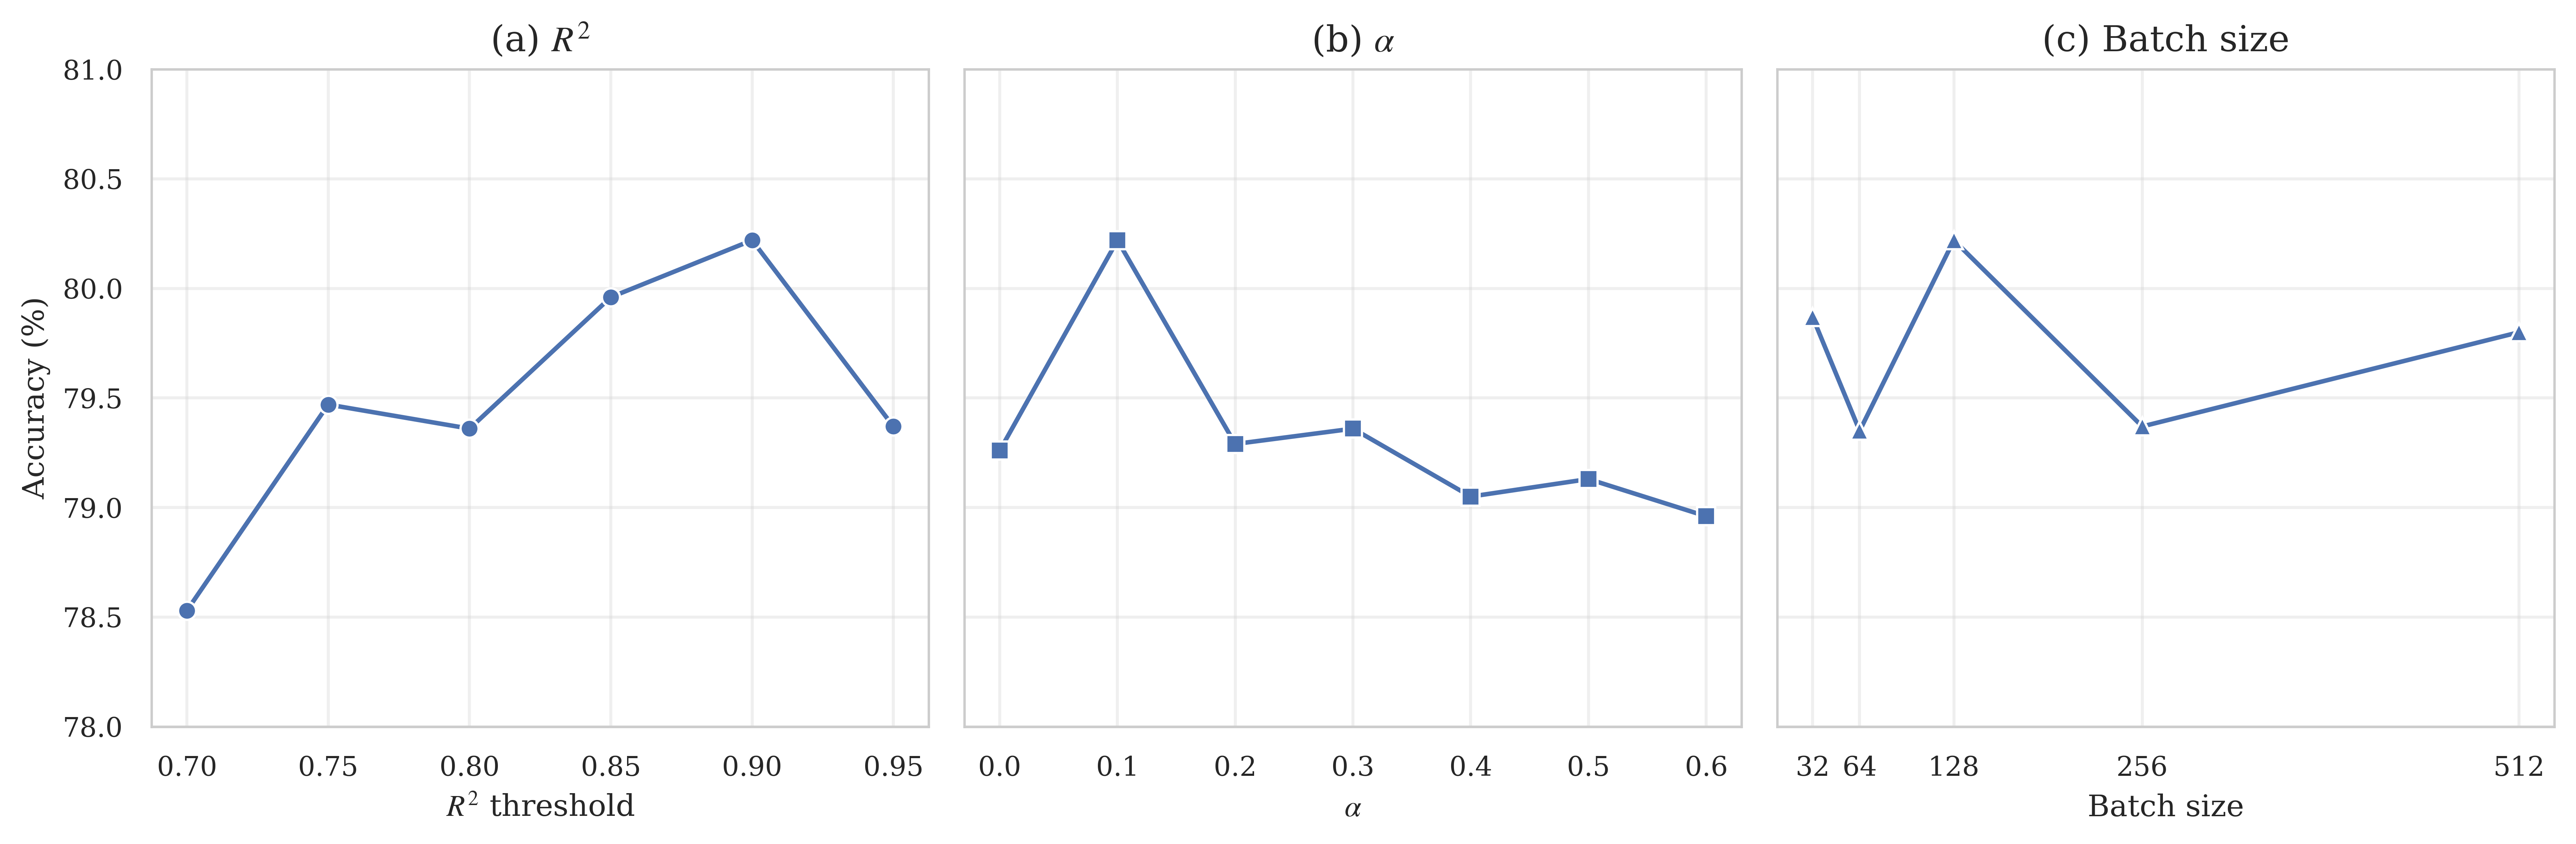

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files  # Colab-specific download helper

# ------------------------------------------------------------------
# 1)  Theme & font configuration (using DejaVu Serif)
# ------------------------------------------------------------------
sns.set_theme(style="whitegrid")
plt.rcParams.update({
    'font.family'      : 'serif',
    'font.serif'       : ['DejaVu Serif'],
    'font.size'        : 10,
    'axes.titlesize'   : 12,
    'axes.labelsize'   : 10,
    'xtick.labelsize'  : 9,
    'ytick.labelsize'  : 9,
    'legend.fontsize'  : 9,
    'figure.dpi'       : 600,
    'figure.figsize'   : (12, 4),
    'grid.alpha'       : 0.3,
    'lines.linewidth'  : 1.5,
    'axes.linewidth'   : 0.8,
    'savefig.bbox'     : 'tight',
    'savefig.transparent': True,
})

# ------------------------------------------------------------------
# 2)  Data
# ------------------------------------------------------------------
r2_thresholds    = [0.95, 0.90, 0.85, 0.80, 0.75, 0.70]
acc_svm_r2       = [79.37, 80.22, 79.96, 79.36, 79.47, 78.53]

alphas           = [0.00, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60]
acc_svm_alpha    = [79.26, 80.22, 79.29, 79.36, 79.05, 79.13, 78.96]

batch_sizes      = [32, 64, 128, 256, 512]
acc_svm_batch    = [79.87, 79.35, 80.22, 79.37, 79.80]

y_min, y_max     = 78, 81
markers          = ['o', 's', '^']

# ------------------------------------------------------------------
# 3)  Three side-by-side plots
# ------------------------------------------------------------------
fig, axes = plt.subplots(1, 3, sharey=True)

sns.lineplot(x=r2_thresholds, y=acc_svm_r2, marker=markers[0], ax=axes[0])
axes[0].set_title('(a) $R^2$')
axes[0].set_xlabel('$R^2$ threshold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_ylim(y_min, y_max)

sns.lineplot(x=alphas, y=acc_svm_alpha, marker=markers[1], ax=axes[1])
axes[1].set_title('(b) $\\alpha$')
axes[1].set_xlabel('$\\alpha$')
axes[1].set_ylim(y_min, y_max)

sns.lineplot(x=batch_sizes, y=acc_svm_batch, marker=markers[2], ax=axes[2])
axes[2].set_title('(c) Batch size')
axes[2].set_xlabel('Batch size')
axes[2].set_xticks(batch_sizes)
axes[2].set_ylim(y_min, y_max)

plt.tight_layout()

# ------------------------------------------------------------------
# 4)  Save and download
# ------------------------------------------------------------------
out_filename = 'svm_results.png'
fig.savefig(out_filename)          # Save as PNG (transparent background & tight bbox)
files.download(out_filename)       # Trigger browser download in Colab

plt.show()
